In [1]:
import torch, random, re
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import youtokentome as yttm
from einops import rearrange
from torch import einsum
from math import sqrt

In [2]:
class GELU(nn.Module):
  def forward(self, x):
    return x * 0.5 * (1 + torch.erf(x / sqrt(2)))

In [3]:
class LayerNorm(nn.Module):
  def __init__(self, d, eps=1e-5):
    super().__init__()
    self.d, self.eps = d, eps
    self.w = nn.Parameter(torch.tensor(1.))
    self.b = nn.Parameter(torch.tensor(0.))

  def forward(self, x):
    for i in range(len(x.shape) - 1, -1, -1):
      if x.shape[i] == self.d:
        d = i
        break
    mu = x.mean(d).unsqueeze(d)  # E[x]
    mu_ = (x * x).mean(d).unsqueeze(d)  # E[x^2]
    sigma = torch.sqrt(mu_ - mu * mu + self.eps)
    return self.w * (x - mu) / sigma + self.b

In [4]:
class Layer(nn.Module):
  def __init__(self, d, nh):
    super().__init__()
    assert d % nh == 0, 'number of heads should divide embedding dim'
    self.d, self.nh, self.h = d, nh, d // nh
    self.wx, self.wo = nn.Linear(d, 3 * d), nn.Linear(d, d)
    self.ln1, self.ln2 = LayerNorm(d), LayerNorm(d)
    self.ffn = nn.Sequential(
      nn.Linear(d, 4 * d), GELU(), nn.Linear(4 * d, d)
    )

    def fn(m):
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.02)
        nn.init.zeros_(m.bias)

    self.apply(fn)

  def forward(self, xma):
    x, m, _ = xma
    qkv = rearrange(self.wx(self.ln1(x)), 'b l D -> b D l')
    q, k, v = rearrange(qkv, 'b (N h) l -> b N h l', h=self.h).split(self.nh, 1)
    A = F.softmax((einsum('bhri, bhrj -> bhij', q, k) + m) / sqrt(self.d), -1)
    H = einsum('bhic, bhjc -> bhij', v, A)
    MHA = rearrange(rearrange(H, 'b nh h l -> b (nh h) l'), 'b d l -> b l d')
    x = x + self.wo(MHA)
    return x + self.ffn(self.ln2(x)), m, A

In [5]:
class GPT(nn.Module):
  def __init__(self, d, nh, nl, l, v):
    super().__init__()
    self.l = l
    self.emb = nn.Embedding(v, d)  # token embeddings 
    nn.init.normal_(self.emb.weight, 0, 0.02)
    self.pos = nn.Parameter(torch.randn(l, d) * 0.02)
    m = torch.tril(torch.ones(l, l)) - 1
    m[m == -1] = float('-inf')
    self.m = nn.Parameter(m, requires_grad=False)  # mask
    self.layers = nn.Sequential(*[Layer(d, nh) for _ in range(nl)])  # layers 
    self.out = nn.Linear(d, v, bias=False)  # embedding to logits projection 
    nn.init.normal_(self.out.weight, 0, 0.02)
    self.size = sum(p.numel() for p in self.parameters() if p.requires_grad)

  def forward(self, t):
    l = t.shape[-1]
    assert l <= self.l, f'input sequence length should be <= {self.l}'
    if len(t.shape) == 1:
      t = t.unsqueeze(0)  # (l,) to (1, l)
    x, m, A = self.emb(t) + self.pos[:l], self.m[:l, :l], None
    As = []
    for layer in self.layers:
      x, m, A = layer((x, m, A))
      As.append(A.detach().squeeze())
    return self.out(x).squeeze(), As

  def loss(self, it, ot):
    return F.cross_entropy(
      rearrange(self(it)[0], 'b l v -> (b l) v'), rearrange(ot, 'b l -> (b l)')
    )

In [6]:
bpe = yttm.BPE('tokenizer.model')
device = torch.device('mps')
model_path = 'HP-Lion-tokenize.pt'
d = 12 * 30
nh = 12
nl = 8
l = 256
v = bpe.vocab_size()

In [7]:
model = GPT(d, nh, nl, l, v).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [8]:
def generate(model, text, n, temp=0.9, device='cpu'):
  assert len(text) > 0 
  enc = bpe.encode(text) 
  tokens = ''.join(list(map(bpe.id_to_subword, enc)))
  print(re.sub('▁', ' ', tokens), end='')
  input_tokens = torch.tensor(enc).to(device)  
  with torch.no_grad():
    for _ in range(n):
      logits, As = model(input_tokens[-model.l:])
      p = F.softmax(logits / temp, -1)[-1]
      token_id = torch.multinomial(p, 1)  # shape (1,)
      if token_id.item() == 105:
        token = '\n'
      else:
        token = re.sub('▁', ' ', bpe.id_to_subword(token_id.item()))
      print(token, end='')
      input_tokens = torch.cat((input_tokens, token_id), -1)
    return input_tokens.cpu().tolist(), [A.cpu() for A in As]

In [9]:
completion, As = generate(model, "Mad-Eye Moody", 100, 0.7, device)

 Mad-Eye Moody ‘mphance of students’ save my
 private lessons with the headstickly, the office, it
 would be unpaid easier to die, while the rest of the
 school was happier to be. Dumbledore’s many more
 things seemed less than yet. There had turned three
 deeper than Sirius and said —

 Then week’s

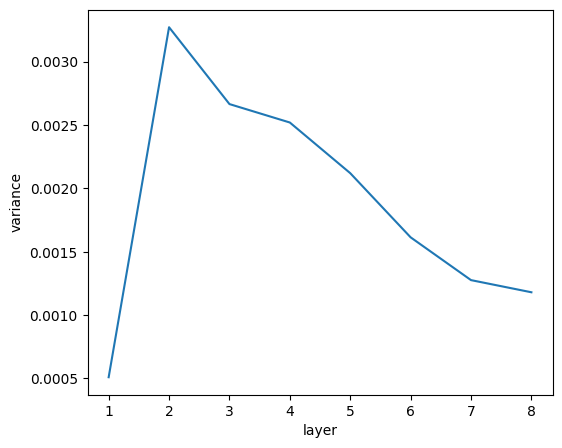

In [10]:
fig = plt.figure(figsize=(6, 5))
plt.xlabel('layer')
plt.ylabel('variance')
plt.xticks(range(1, len(As) + 1))
plt.plot(range(1, len(As) + 1), [A.var().item() for A in As])
plt.show()

In [11]:
begin, end = 0, 64

# get completion chunk
chunk = list(map(bpe.id_to_subword, completion))[begin:end]
chunk = [x if x != '▁<|newline|>' else '\\n' for x in chunk]
print(
  re.sub('\s*<\|newline\|>\s*', '\n', bpe.decode(completion[begin:end])[0])
)

# get attention matrix chunks
As = [A[:, begin:end, begin:end] for A in As]


# shows attention matrix j of layer i
def attention(i, j):
  A = As[i][j].numpy()
  plt.rcParams["figure.figsize"] = [8, 8]
  plt.rcParams["figure.autolayout"] = True
  fig, ax = plt.subplots(1, 1)
  plt.title(f'layer {i}, head {j}', size=9)
  ax.tick_params(axis='both', which='major', labelsize=7)
  plt.xticks(range(len(chunk)), chunk)
  plt.setp(ax.get_xticklabels(), rotation=90)
  plt.yticks(range(len(chunk)), chunk)
  plt.imshow(A)
  plt.show()


# shows how token i attends to every other token in each layer
# for each layer, displays an n x l matrix T where n is # heads
# and l is completion length. T_ab = Q_ai ⋅ K_ab where a is the
# head number and b is the token being attended to. Q_ai and
# K_ab are row i and row b of Q and K matrices respectively of
# head a
def attention_for_token(i):
  zeros = np.zeros((1, end - begin))
  heads = [np.concatenate((zeros, A[:, i].cpu().numpy())) for A in As]
  plt.rcParams["figure.figsize"] = [18 * len(heads), 18]
  plt.rcParams["figure.autolayout"] = True
  fig, axs = plt.subplots(len(heads), 1)
  for j, (head, ax) in enumerate(zip(heads, axs)):
    ax.set_title(f'layer {j}, attention for ' + repr(chunk[i]), size=9)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.set_ylim(0.5, head.shape[0] - 0.5)
    ax.set_yticks(range(1, head.shape[0]))
    ax.set_ylabel('head', size=7)
    ax.set_xticks(range(end - begin), chunk, rotation=90)
    ax.imshow(head)

Mad-Eye Moody ‘mphance of students’ save my
private lessons with the headstickly, the office, it
would be unpaid easier to die, while the rest of the


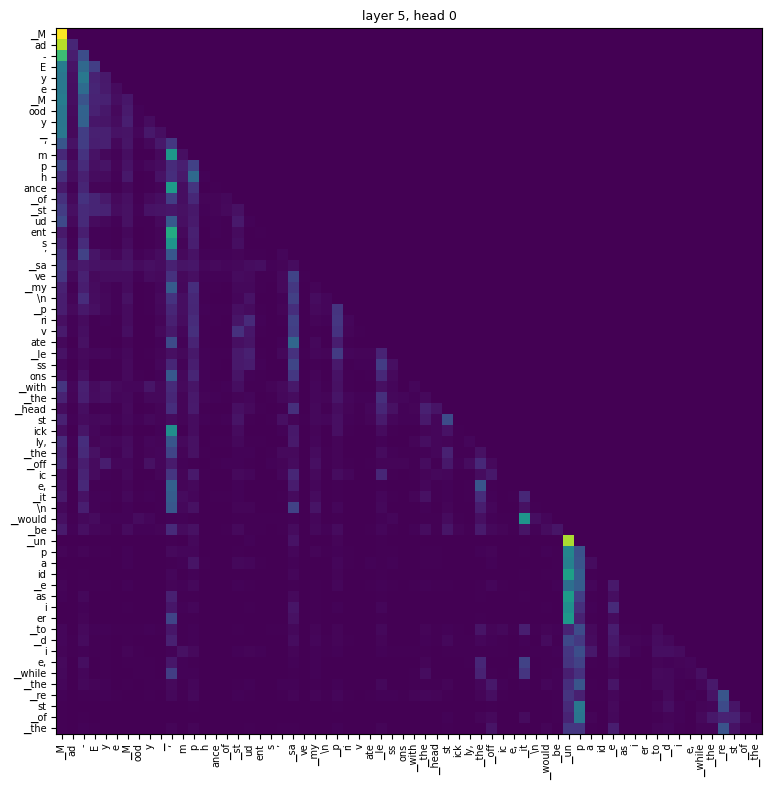

In [12]:
attention(5, 0)

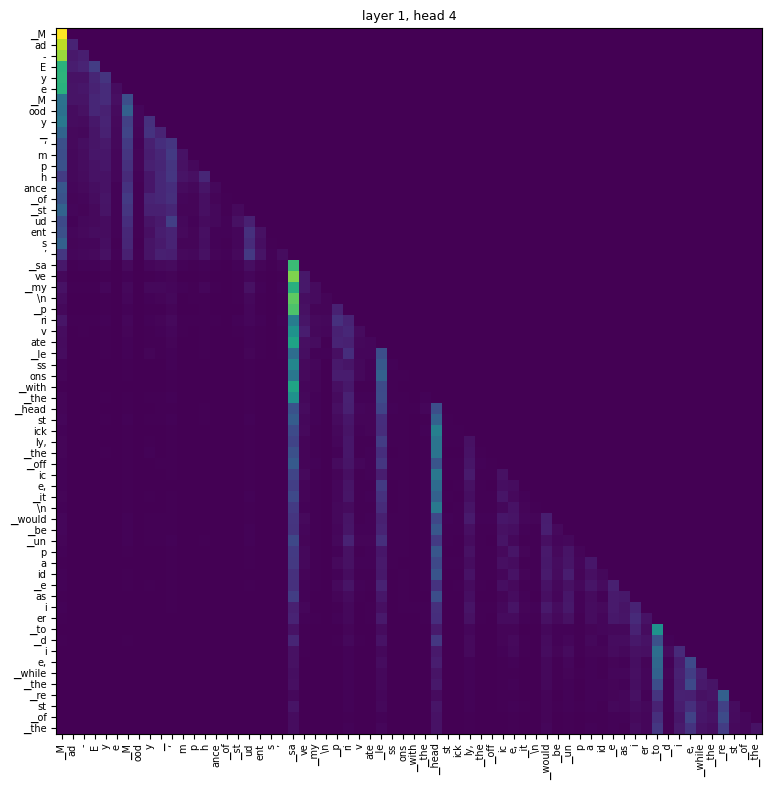

In [13]:
attention(1, 4)

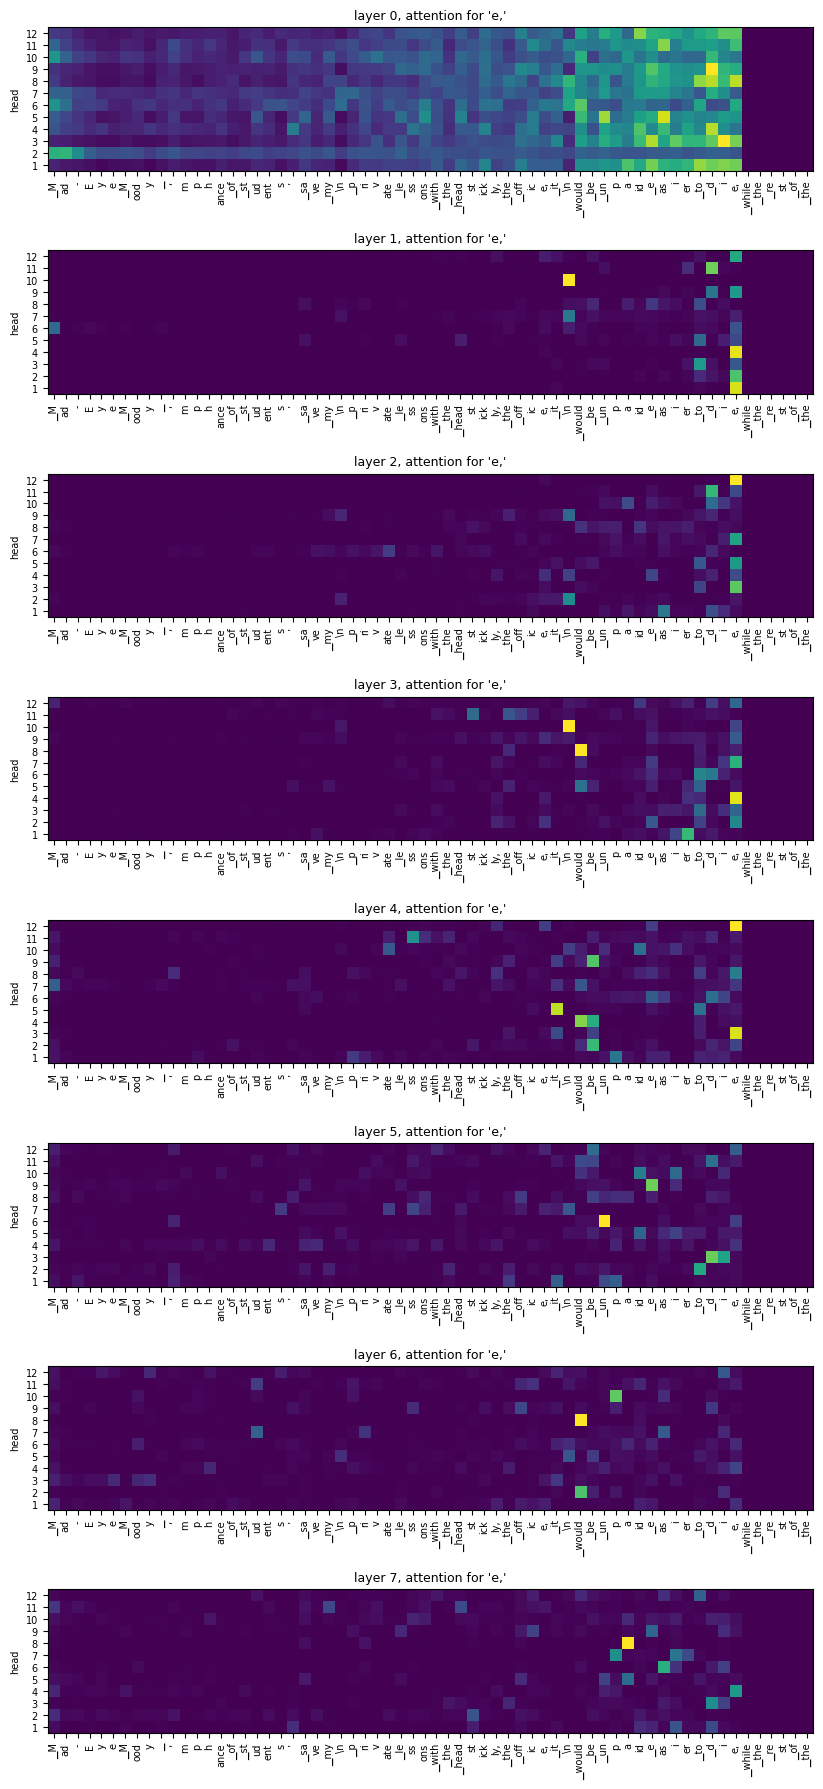

In [14]:
attention_for_token(-7)